# Data loading

In [76]:
IMPORT_PATH = '../Initial_Data/Unzipped'
IMPORT_ALL_PATH = IMPORT_PATH + '/*'

import pandas as pd
import numpy as np
import glob as glob

def readAllFiles():
    files = glob.glob(IMPORT_ALL_PATH)
    frames = []

    for file in files:
        df = pd.read_csv(file, index_col = 0)
        frames.append(df)

    return pd.concat(frames)

def readOneFile(url):
    return pd.read_csv(url, index_col = 0)

df = readAllFiles()

# Cleaning functions

In [77]:
import pandas as pd
import numpy as np
import glob as glob
from math import *

usaStates = [
    "AL",
    "AK",
    "AZ",
    "AR",
    "CA",
    "CO",
    "CT",
    "DE",
    "FL",
    "GA",
    "HI",
    "ID",
    "IL",
    "IN",
    "IA",
    "KS",
    "KY",
    "LA",
    "ME",
    "MD",
    "MA",
    "MI",
    "MN",
    "MS",
    "MO",
    "MT",
    "NE",
    "NV",
    "NH",
    "NJ",
    "NM",
    "NY",
    "NC",
    "ND",
    "OH",
    "OK",
    "OR",
    "PA",
    "RI",
    "SC",
    "SD",
    "TN",
    "TX",
    "UT",
    "VT",
    "VA",
    "WA",
    "WV",
    "WI",
    "WY",
]

def deleteWrongStates(df):
    print("Aantal records:", len(df))
    
    for el in df.departure_state.unique():
        if(el not in usaStates):
            df = df.drop(df[df['departure_state'] == el].index)
    print("Aantal records na verwijderen foute vertrek staat:", len(df))

    for el in df.arrival_state.unique():
        if(el not in usaStates):
            df = df.drop(df[df['arrival_state'] == el].index)
    print("Aantal records na verwijderen foute aankomst staat:", len(df))
          
    return df

def convertColumnTypes(df):
    df.departure_schedule = df.departure_schedule.astype(int)
    df.departure_delay = df.departure_delay.astype(float)
    df.arrival_schedule = df.arrival_schedule.astype(int)
    df.arrival_delay = df.arrival_delay.astype(float)
    df.arrival_actual = df.arrival_actual.astype(int)
    df.departure_actual = df.departure_actual.astype(int)
    return df

def dropMoreAdvancedDuplicates(df):
    df = df.groupby(['date', 'airline', 'airline_code', 'departure_airport', 'departure_state', 'departure_lat', 'departure_lon', 'departure_schedule', 'arrival_airport', 'arrival_state', 'arrival_lat', 'arrival_lon', 'arrival_schedule']).mean().reset_index()
    df = convertColumnTypes(df)
    if 'index' in df.columns:
        df = df.drop(['index'], axis=1) #remove old index
    return df


In [78]:
# Controleer of er records zijn die een vertrektijd hebben die vroeger is dan de aankomsttijd
# Omdat de aankomstdatum niet bijgehouden wordt, kan je niet zeker zijn of het de volgende dag is een een fout record
# Daarom controleren we ook nog of de geplande vliegtijd meer dan x aantal minuten te snel is
# We hebben geen extreme waardes gevonden en daarom geen records verwijderd
df[(df.departure_schedule > df.arrival_schedule) & ((df.arrival_delay - df.departure_delay) < -80)]

,airline,airline_code,departure_airport,departure_state,departure_lat,departure_lon,arrival_airport,arrival_state,arrival_lat,arrival_lon,departure_schedule,departure_actual,departure_delay,arrival_schedule,arrival_actual,arrival_delay
date,,,,,,,,,,,,,,,,


## Convert military time to datetime

In [79]:
import math
from datetime import datetime

def getTotalMinutes(time):
    time_str = str(time).rjust(4, "0")
    hours = time_str[:-2]
    hours = int(hours)
    if hours == 24:
        hours = 0
    minutes = int(time_str[-2:])
    return datetime(2010, 1, 1, hours, minutes, 0)

def convertMilitaryTime(df):
    df["departure_schedule"] = df["departure_schedule"].map(getTotalMinutes)
    df["arrival_schedule"] = df["arrival_schedule"].map(getTotalMinutes)
    return df

## Add timezones

In [80]:
# UTC offset by state
timezones = {
    "AL" :-6,
    "AK" :-9,
    "AZ" :-7,
    "AR" :-6,
    "CA" :-8,
    "CO" :-7,
    "CT" :-5,
    "DE" :-5,
    "FL" :-5,
    "GA" :-5,
    "HI" :-10,
    "ID" :-7,
    "IL" :-6,
    "IN" :-5,
    "IA" : -6,
    "KS" : -6,
    "KY" : -6,
    "LA" : -6,
    "ME" : -5,
    "MD" : -5,
    "MA" : -5,
    "MI" : -5,
    "MN" : -6,
    "MS" : -6,
    "MO" : -6,
    "MT" : -7,
    "NE" : -6,
    "NV" : -8,
    "NH" : -5,
    "NJ" : -5,
    "NM" : -7,
    "NY" : -5,
    "NC" : -5,
    "ND" : -6,
    "OH" : -5,
    "OK" : -6,
    "OR" : -8,
    "PA" : -5,
    "RI" : -5,
    "SC" : -5,
    "SD" : -6,
    "TN" : -6,
    "UT": -7,
    "TX": -6,
    "VT": -5,
    "VA": -5,
    "WA": -8,
    "DC": -5,
    "WV": -5,
    "WI": -6,
    "WY": -5
}

def addTimezones(df):
    df['arrival_tz'] = df['arrival_state'].map(lambda state: timezones[state])
    df['departure_tz'] = df['departure_state'].map(lambda state: timezones[state])
    return df

## Change local time to UTC

In [81]:
from datetime import timedelta

def timeToUTC(schedule, tz):
    tdelta = timedelta(hours=abs(tz))
    if tz > 0:
        schedule -= tdelta
    else:
        schedule += tdelta
    return schedule

def convertLocalToUTC(df):
    arrival_schedules = []
    departure_schedules = []
    for i, row in df.iterrows():
        arrival_schedule = row["arrival_schedule"]
        arrival_tz = row["arrival_tz"]
        departure_schedule = row["departure_schedule"]
        departure_tz = row["departure_tz"]

        arrival_schedules.append(timeToUTC(arrival_schedule, arrival_tz))
        departure_schedules.append(timeToUTC(departure_schedule, departure_tz))

    df["arrival_schedule"] = arrival_schedules
    df["departure_schedule"] = departure_schedules
    return df

## Calculate duration

In [82]:
def addDurations(df): 
    durations = []
    for i, row in df.iterrows():
        arrival = row["arrival_schedule"]
        departure = row["departure_schedule"]
        if arrival <= departure:
            arrival += timedelta(days=1)
        durations.append(arrival - departure)

    df["duration"] = durations
    return df

## Calculate distance

In [83]:
def addDistances(df):
    distances = []
    for index, row in df.iterrows():
        distances.append(calcTheDistance(row))
    df["distance"] = distances
    return df

def calcTheDistance(el):
    slat = radians(float(el["arrival_lat"]))
    slon = radians(float(el["arrival_lon"]))
    elat = radians(float(el["departure_lat"]))
    elon = radians(float(el["departure_lon"]))
    return 6371.01 * acos(sin(slat)*sin(elat) + cos(slat)*cos(elat)*cos(slon - elon))

## Calculate speed

In [84]:
def addSpeed(df):
    speeds = []
    for i, row in df.iterrows():
        duration = row["duration"]
        speed = row["distance"] / ((duration.total_seconds() / 60) / 60)
        speeds.append(speed)

    df["speed"] = speeds
    return df

## Remove too long and too short flights

In [85]:
def deleteImpossibleFlights(df):
    shortest_distance_in_us = 100 #KM
    longest_distance_in_us = 9000 #KM
    shortest_duration_in_us = timedelta(minutes=16)
    longest_duration_in_us = timedelta(hours=11, minutes=40)

    df = df[df.distance.between(shortest_distance_in_us, longest_distance_in_us)]
    df = df[df.duration.between(shortest_duration_in_us,longest_duration_in_us)]
    return df

# Execute cleaning

In [86]:
print("Aantal records om te beginnen:", len(df))
cleaning = df

cleaning = cleaning.drop_duplicates()
print("Aantal records na verwijderen van dubbels:", len(cleaning))

cleaning = cleaning.reset_index()
print("Aantal records na nieuwe index:", len(cleaning))

cleaning = cleaning.dropna()
print("Aantal records na verwijderen lege waarden:", len(cleaning))

cleaning = deleteWrongStates(cleaning)
cleaning = convertColumnTypes(cleaning)

cleaning = dropMoreAdvancedDuplicates(cleaning)
print("Aantal records na het verwijderen van de verborgen dubbels:", len(cleaning))

cleaning = convertMilitaryTime(cleaning)
cleaning = addTimezones(cleaning)
cleaning = convertLocalToUTC(cleaning)
cleaning = addDurations(cleaning)
cleaning = addDistances(cleaning)
cleaning = addSpeed(cleaning)

cleaning = deleteImpossibleFlights(cleaning)
print("Aantal records na het verwijderen van de onmogelijk lange of korte vluchten:", len(cleaning))

cleanData = cleaning

Aantal records om te beginnen: 11401196
Aantal records na verwijderen van dubbels: 10751921
Aantal records na nieuwe index: 10751921
Aantal records na verwijderen lege waarden: 10751919
Aantal records: 10751919
Aantal records na verwijderen foute vertrek staat: 10695506
Aantal records na verwijderen foute aankomst staat: 10642322
Aantal records na het verwijderen van de verborgen dubbels: 10642032
Aantal records na het verwijderen van de onmogelijk lange of korte vluchten: 10552133


# Plot

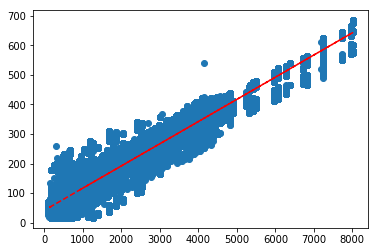

In [88]:
import matplotlib.pyplot as plt

plot_data = cleaning

x = plot_data['distance']
y = plot_data['duration'].map(lambda tdelta: tdelta.total_seconds() / 60)
plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")

plt.show()

# Export df to csv

In [87]:
EXPORT_PATH = '../Data'

def exportDfToCsvFiles(df):
    step = 1000000
    start = 0
    stop = step
    i = 0

    while start < len(df):
        if stop >= len(df):
            stop = len(df)
        fileName = EXPORT_PATH +  '/flights_2010_' + str(i) + '.csv'
        
        data = df.iloc[start:stop, 0:]
        data.to_csv( fileName, sep=',')

        start += step
        stop += step
        i += 1

exportDfToCsvFiles(cleanData)

# Functions for json

### Export everything to json

In [90]:
#creating a json file
cleanData.rename(columns={"distance": "Distance", "duration": "scheduled flight time", "speed": "Average speed"}, inplace=True)
cleanData.to_json('flights_2010_file_time_update_versie_2.json', orient='records')

### Export selected part to json

In [15]:
#selecting SouthWest Airlines
df_southWest = cleanData.loc[df['airline'] == "WN"]
#selecting Alaska Airlines
df_alaska = cleanData.loc[df['airline'] == "AS"]
#selecting Hawaiian Airlines
df_hawaiian = cleanData.loc[df['airline'] == "HA"]

In [16]:
df_southWest = df_southWest[['date', 'departure_airport','departure_state',
                          'departure_lat', 'departure_lon',
                          'arrival_airport', 'arrival_state',
                          'arrival_lat', 'arrival_lon']]
df_alaska = df_alaska[['date', 'departure_airport','departure_state',
                          'departure_lat', 'departure_lon',
                          'arrival_airport', 'arrival_state',
                          'arrival_lat', 'arrival_lon']]
df_hawaiian = df_hawaiian[['date', 'departure_airport','departure_state',
                          'departure_lat', 'departure_lon',
                          'arrival_airport', 'arrival_state',
                          'arrival_lat', 'arrival_lon']]

In [29]:
#creating a json file for SouthWest Airlines
df_southWest.to_json('SouthWest_Airlines.json', orient='records')

In [30]:
#creating a json file for Alaska Airlines
df_southWest.to_json('Alaska_Airlines.json', orient='records')

In [31]:
#creating a json file for Hawaiian Airlines
df_southWest.to_json('Hawaiian_Airlines.json', orient='records')